## Plotting composites ##

Plotting composites for two types of very bad winter days across three datasets: ERA5, DePreSys (10 members, Nov. init, first DJF), and CANARI (40 members, DJF).

1. Worst wind cold temp events - for each winter, this is where I've selected the day with the lowest wind speed and taken the corresponding temperature on that 'worst wind' day. I have then plotted these as a scatter and identified the very bad days, which are in both the 0th-50th percentile of the wind speeds for worst wind days and 0th-50th percentile of temperature for the worst temp days. These very bad days are what I am plotting as composites here.

2. Worst temp low wind events, same as above, but for the lowest temperature and then taking the corresponding wind speed.

In [1]:
# Imports
import os
import sys
import glob
import time
import re

# Third-party libraries
import numpy as np
import pandas as pd
import xarray as xr
import iris
import iris.coords
import cftime
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
import cartopy.crs as ccrs

# Specific third-party imports
from matplotlib import colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm
from scipy.stats import pearsonr
from iris.util import equalise_attributes

# Import types
from typing import Any, Callable, Union, List, Tuple

# Local imports
from plotting_functions import format_func, format_func_one_decimal

# Non-local imports
sys.path.append("/home/users/benhutch/unseen_functions/")
from functions import plot_dps_composite, plot_daily_field

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# # Set up the file to the
# worst_temp_path = (
#     "/home/users/benhutch/unseen_multi_year/dfs/obs_worst_temp_low_wind_djf.csv"
# )
# worst_wind_path = (
#     "/home/users/benhutch/unseen_multi_year/dfs/obs_worst_wind_cold_temp_djf.csv"
# )

# # load these datarames
# worst_temp = pd.read_csv(worst_temp_path)
# worst_wind = pd.read_csv(worst_wind_path)

In [3]:
# # extract the worst temp dates
# worst_temp_dates = worst_temp["time_worst_tas_date"].values
# worst_temp_dates = pd.to_datetime(worst_temp_dates)

# # extract the worst wind dates
# worst_wind_dates = worst_wind["time_worst_wind_date"].values
# worst_wind_dates = pd.to_datetime(worst_wind_dates)

# # print these
# print(worst_temp_dates)
# print(worst_wind_dates)

In [4]:
# # Set up the path to the data
# data_path = (
#     ""hours since 1900-01-01"
# )

# # Load the data
# psl_cube = iris.load_cube(data_path, "msl")

In [5]:
# Set up the path to the dfs
temp_path = (
    "/home/users/benhutch/unseen_multi_year/dfs/djf_percs_5_temp_dates.csv"
)
elec_path = (
    "/home/users/benhutch/unseen_multi_year/dfs/djf_percs_5_elec_dates.csv"
)

# Load the dataframes
temp_df = pd.read_csv(temp_path)
elec_df = pd.read_csv(elec_path)

In [6]:
# set up the data path to the temp data
temp_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_t2m_daily_1950_2020.nc"

# Load the data
temp_cube = iris.load_cube(temp_path, "t2m")

In [7]:
# extract lats and lons
lats = temp_cube.coord("latitude").points
lons = temp_cube.coord("longitude").points

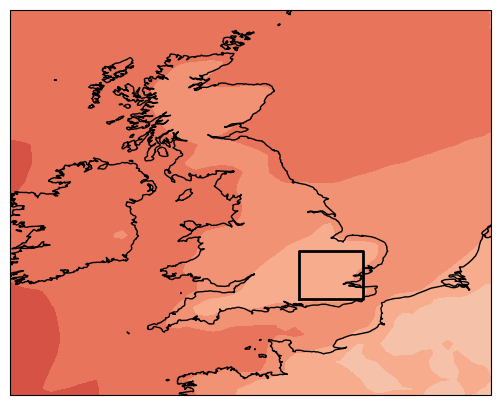

In [11]:
# plot the first time point of the temp cube
# using cartopy
plt.figure(figsize=(10, 5))

# Set up the projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
temp_first = temp_cube[0, :, :]

# plot the data
temp_first = temp_first.data

# include coastlines
ax.coastlines()

# plot the data
plt.contourf(
    lons,
    lats,
    temp_first,
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    levels=20,
    extend="both",
)

# limit to a focus on the UK region
ax.set_extent([-10, 5, 48, 60], crs=ccrs.PlateCarree())

# set up a box for southern engalnd
south_east_england_box = {
    "lat1": 50.5,
    "lat2": 54,
    "lon1": -3,
    "lon2": 1,
}

south_east_england_box = {
    "lat1": 51,
    "lat2": 52.5,
    "lon1": -1,
    "lon2": 1,
}

# plot this box
plt.plot(
    [south_east_england_box["lon1"], south_east_england_box["lon1"], south_east_england_box["lon2"], south_east_england_box["lon2"], south_east_england_box["lon1"]],
    [south_east_england_box["lat1"], south_east_england_box["lat2"], south_east_england_box["lat2"], south_east_england_box["lat1"], south_east_england_box["lat1"]],
    color="black",
    linewidth=2,
    transform=ccrs.PlateCarree(),
)

In [12]:
%%time

# extract the times from the full temp cube
times = temp_cube.coord("time").points

# subset the cube to the south england box
temp_cube_se = temp_cube.intersection(
    latitude=(south_east_england_box["lat1"], south_east_england_box["lat2"]),
    longitude=(south_east_england_box["lon1"], south_east_england_box["lon2"]),
)

# extract the data
temp_cube_se_mean = temp_cube_se.collapsed(["latitude", "longitude"], iris.analysis.MEAN)

# extract the data
temp_cube_se_mean_data = temp_cube_se_mean.data

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(


CPU times: user 728 ms, sys: 54.1 s, total: 54.9 s
Wall time: 8min 45s


In [13]:
temp_cube_se_mean_data.shape

(25933,)

In [14]:
# set up a new dataframe
temp_df_se = pd.DataFrame()

# set up the columns
temp_df_se["time"] = times
temp_df_se["t2m_south_england"] = temp_cube_se_mean_data

In [15]:
# Now convert time to proper units
# days since 1950-01-01 00:00:00
# "proleptic_gregorian"
temp_df_se["time"] = pd.to_datetime(temp_df_se["time"], unit="D", origin="1950-01-01")

In [16]:
temp_df_se.head()

time  t2m_south_england
0 1950-01-01         274.652466
1 1950-01-02         280.524841
2 1950-01-03         282.855438
3 1950-01-04         281.720154
4 1950-01-05         280.954132

In [17]:
# south_england_box = {
#     "lat1": 50.5,
#     "lat2": 54,
#     "lon1": -3,
#     "lon2": 1,
# }

# # set up the fname
fname_temp = "t2m_south_england_ERA5_1950_2020_south_east_england_box.csv"

# save the dataframe
# set up the save direc
save_dir = "/home/users/benhutch/unseen_multi_year/dfs/"

# save the dataframe
temp_df_se.to_csv(os.path.join(save_dir, fname_temp), index=False)

In [14]:
# temp_df.head()

In [15]:
# subset temp_df to the first 5 rows
temp_df_subset = temp_df.iloc[:5, :]

In [16]:
temp_df_subset

percentile   threshold  n_days  \
0         2.5  266.305164     157   
1         3.5  270.034112     156   
2         4.5  270.988770     157   
3         5.5  271.847425     157   
4         6.5  272.247937     156   

                                         valid_dates  mean_10m_U  mean_10m_V  \
0  ['1979-01-01', '1979-01-02', '1979-01-03', '19...   -1.329917   -0.682912   
1  ['1979-01-02', '1979-01-03', '1979-01-04', '19...   -1.245973   -0.515921   
2  ['1979-01-02', '1979-01-03', '1979-01-04', '19...   -1.129777   -0.327641   
3  ['1979-01-03', '1979-01-04', '1979-01-14', '19...   -1.105621   -0.493577   
4  ['1979-01-14', '1979-01-22', '1979-01-23', '19...   -1.067463   -0.576404   

   mean_10m_wind_speed  mean_100m_U  mean_100m_V  mean_100m_wind_speed  \
0             3.053934    -2.138685    -1.091224              5.085798   
1             3.048414    -1.988931    -0.829598              5.080833   
2             3.038385    -1.781971    -0.510807              5.046287   
3             2.998550    -1.774975    -0.772284              4.980599   
4             3.048675    -1.726035    -0.913350              5.051816   

        mean_psl  mean_nao  mean_delta_p  
0  101562.911832 -1.775397      4.612603  
1  101619.862442 -0.739039      3.719774  
2  101615.101977  0.578816      2.918234  
3  101586.739141  1.754294      2.543267  
4  101518.866577  2.335145      2.225345

In [17]:
# Subset the elec df to the last 5 rows
elec_df_subset = elec_df.iloc[-5:, :]

In [18]:
elec_df_subset

percentile    threshold  n_days  \
91        93.5  1030.298426     156   
92        94.5  1033.320140     157   
93        95.5  1037.009673     157   
94        96.5  1041.830553     156   
95        97.5  1046.513439     156   

                                          valid_dates  mean_10m_U  mean_10m_V  \
91  ['1979-01-10', '1979-01-11', '1979-01-12', '19...   -1.303695   -0.235727   
92  ['1979-01-06', '1979-01-07', '1979-01-10', '19...   -1.482749   -0.244746   
93  ['1979-01-06', '1979-01-07', '1979-01-10', '19...   -1.491346   -0.287723   
94  ['1979-01-06', '1979-01-07', '1979-01-11', '19...   -1.871161   -0.341237   
95  ['1979-01-01', '1979-01-02', '1979-01-03', '19...   -2.126575   -0.516853   

    mean_10m_wind_speed  mean_100m_U  mean_100m_V  mean_100m_wind_speed  \
91             3.309813    -2.096721    -0.338343              5.474099   
92             3.463972    -2.375728    -0.319630              5.698236   
93             3.482316    -2.365876    -0.408529              5.710302   
94             3.751544    -2.949124    -0.481610              6.132307   
95             3.818752    -3.348744    -0.737645              6.216757   

         mean_psl  mean_nao  mean_delta_p  
91  101930.192912  3.409173      2.330476  
92  101936.091922  3.971873      2.312656  
93  101945.694014  2.934738      2.470089  
94  101858.621264  0.107103      4.089840  
95  101826.439881 -0.953422      5.437595

In [19]:
# collapse the valid dates into a single list
valid_dates_temp = temp_df_subset["valid_dates"].values

In [20]:
(valid_dates_temp)

array(["['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04', '1979-01-05', '1979-01-12', '1979-01-13', '1979-01-26', '1979-01-27', '1979-01-28', '1979-02-06', '1979-02-08', '1979-02-14', '1979-02-15', '1979-02-16', '1979-02-17', '1980-01-01', '1980-01-02', '1980-02-01', '1981-12-08', '1981-12-09', '1981-12-10', '1981-12-11', '1981-12-12', '1981-12-13', '1981-12-16', '1981-12-17', '1981-12-18', '1981-12-19', '1981-12-22', '1981-12-23', '1981-12-24', '1981-12-25', '1982-01-06', '1982-01-07', '1982-01-08', '1982-01-09', '1982-01-10', '1982-01-11', '1982-01-12', '1982-01-13', '1982-01-14', '1982-01-15', '1983-02-10', '1984-01-20', '1984-01-25', '1985-01-14', '1985-01-15', '1985-01-16', '1985-01-17', '1985-01-26', '1985-02-09', '1985-02-10', '1985-02-11', '1985-02-12', '1985-02-13', '1985-02-14', '1985-02-15', '1985-02-16', '1985-12-27', '1985-12-28', '1985-12-29', '1985-12-30', '1986-02-06', '1986-02-07', '1986-02-08', '1986-02-09', '1986-02-10', '1986-02-11', '1986-02-20', '1986-02-21

In [21]:
import ast

# create an empty list
dates_list_full = []

# loop over the strings and convert to datetime
for i, date in enumerate(valid_dates_temp):
    dates_list = ast.literal_eval(date)

    # loop over the dates and convert to datetime
    for date_this in dates_list:
        if date_this not in dates_list_full:
            dates_list_full.append(date_this)

# format the list full as datetimes
dates_list_full = pd.to_datetime(dates_list_full)    

In [22]:
dates_list_full

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-12', '1979-01-13', '1979-01-26',
               '1979-01-27', '1979-01-28',
               ...
               '1997-01-04', '2001-01-18', '2001-12-29', '2003-12-29',
               '2007-12-21', '2009-01-05', '2010-01-30', '2010-02-19',
               '2010-02-23', '2013-01-21'],
              dtype='datetime64[ns]', length=282, freq=None)

In [23]:
# do the same for the valid dates electricity
valid_dates_elec = elec_df_subset["valid_dates"].values

# create an empty list
dates_list_full_elec = []

# loop over the strings and convert to datetime
for i, date in enumerate(valid_dates_elec):
    dates_list = ast.literal_eval(date)

    # loop over the dates and convert to datetime
    for date_this in dates_list:
        if date_this not in dates_list_full_elec:
            dates_list_full_elec.append(date_this)

# format the list full as datetimes
dates_list_full_elec = pd.to_datetime(dates_list_full_elec)

In [24]:
dates_list_full

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-12', '1979-01-13', '1979-01-26',
               '1979-01-27', '1979-01-28',
               ...
               '1997-01-04', '2001-01-18', '2001-12-29', '2003-12-29',
               '2007-12-21', '2009-01-05', '2010-01-30', '2010-02-19',
               '2010-02-23', '2013-01-21'],
              dtype='datetime64[ns]', length=282, freq=None)

In [25]:
# convert dates_list_full to a list of strings
dates_list_full_str = [str(date) for date in dates_list_full]
dates_list_full_elec_str = [str(date) for date in dates_list_full_elec]

In [26]:
overlap_dates = []
unique_temp_dates = []
unique_elec_dates = []


# assert that the two lists are different
# loop over the dates list ful electricity
for i, date_this in enumerate(dates_list_full_str):
    if date_this in dates_list_full_elec_str:
        overlap_dates.append(date_this)
    else:
        unique_temp_dates.append(date_this)

# loop over the dates list full electricity
for i, date_this in enumerate(dates_list_full_elec_str):
    if date_this not in dates_list_full_str:
        unique_elec_dates.append(date_this)

In [27]:
len(overlap_dates)

143

In [28]:
len(unique_temp_dates)

139

In [29]:
unique_elec_dates

['1979-01-10 00:00:00',
 '1979-01-11 00:00:00',
 '1979-01-17 00:00:00',
 '1979-01-30 00:00:00',
 '1979-02-01 00:00:00',
 '1979-02-10 00:00:00',
 '1979-02-11 00:00:00',
 '1979-02-12 00:00:00',
 '1979-02-19 00:00:00',
 '1980-01-12 00:00:00',
 '1980-01-13 00:00:00',
 '1980-01-15 00:00:00',
 '1980-01-16 00:00:00',
 '1981-12-20 00:00:00',
 '1985-01-09 00:00:00',
 '1985-01-10 00:00:00',
 '1985-01-24 00:00:00',
 '1985-02-19 00:00:00',
 '1986-01-07 00:00:00',
 '1986-01-08 00:00:00',
 '1986-02-04 00:00:00',
 '1986-02-16 00:00:00',
 '1986-02-17 00:00:00',
 '1987-12-09 00:00:00',
 '1987-12-10 00:00:00',
 '1989-12-13 00:00:00',
 '1990-12-18 00:00:00',
 '1990-12-19 00:00:00',
 '1991-01-15 00:00:00',
 '1991-01-16 00:00:00',
 '1991-01-29 00:00:00',
 '1991-01-30 00:00:00',
 '1991-12-10 00:00:00',
 '1991-12-13 00:00:00',
 '1992-01-24 00:00:00',
 '1992-01-28 00:00:00',
 '1996-01-23 00:00:00',
 '1996-02-02 00:00:00',
 '1996-02-03 00:00:00',
 '1996-02-04 00:00:00',
 '1996-02-05 00:00:00',
 '1996-02-08 00:

In [31]:
# convert unique_temp_dates to datetime
unique_temp_dates = pd.to_datetime(unique_temp_dates)

Dates to extract: [cftime.datetime(1979, 1, 13, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1979, 1, 27, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1979, 1, 28, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1980, 1, 1, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1980, 1, 2, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1980, 2, 1, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1981, 12, 8, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1981, 12, 9, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1981, 12, 10, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1981, 12, 11, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1981, 12, 12, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1981, 12, 13, 0, 0, 0, 0, calendar='stand

Average over 139 dates


/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


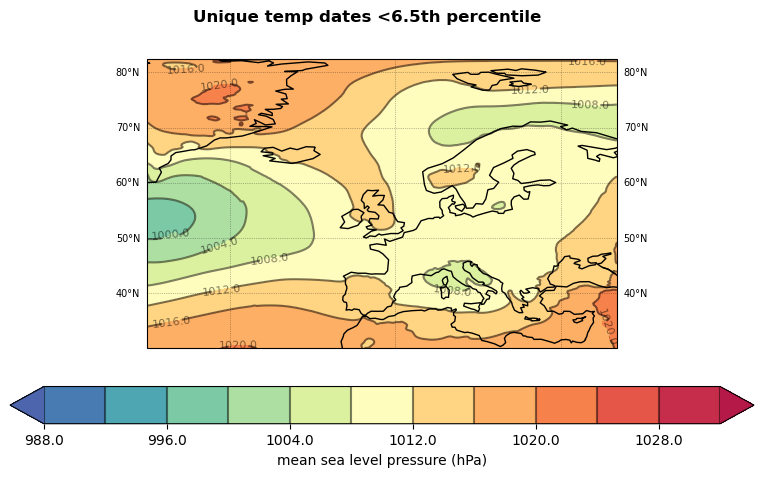

In [33]:
# test the function
plot_daily_field(
    cube=psl_cube,
    dates=unique_temp_dates,
    title="Unique temp dates <6.5th percentile",
    anoms=False,
    composite=True,
    months=[12, 1, 2],
    climatology_years=[1990, 2020],
)

In [35]:
# convert unique_elec_dates to datetime
unique_elec_dates = pd.to_datetime(unique_elec_dates)

Dates to extract: [cftime.datetime(1979, 1, 10, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1979, 1, 11, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1979, 1, 17, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1979, 1, 30, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1979, 2, 1, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1979, 2, 10, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1979, 2, 11, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1979, 2, 12, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1979, 2, 19, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1980, 1, 12, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1980, 1, 13, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1980, 1, 15, 0, 0, 0, 0, calendar='standar

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


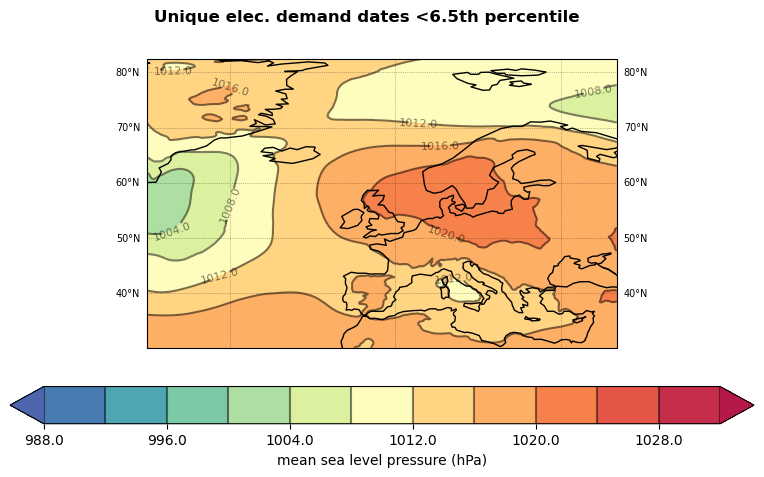

In [37]:
# test the function
plot_daily_field(
    cube=psl_cube,
    dates=unique_elec_dates,
    title="Unique elec. demand dates <6.5th percentile",
    anoms=False,
    composite=True,
    months=[12, 1, 2],
    climatology_years=[1990, 2020],
)

In [6]:
# # Extract the new df
# path = "/home/users/benhutch/unseen_multi_year/dfs/ERA5_worst_djf_wind_temp_days_DJF_1960-2013.csv"

# full_obs_df = pd.read_csv(path)

In [7]:
# # Subset to the lowest 20th percentile of wind ("data_wind")
# data_wind_20th = full_obs_df["data_wind"].quantile(0.2)

# # Subset to the lowest 20th percentile of temperature ("data_tas")
# full_obs_df_subset_20th_wind = full_obs_df[full_obs_df["data_wind"] <= data_wind_20th]


In [8]:
# # extract the dates from this
# worst_wind_20th_dates = full_obs_df_subset_20th_wind["time_worst_wind_date"].values

In [9]:
# # convert these to datetime objects
# worst_wind_20th_dates = pd.to_datetime(worst_wind_20th_dates)

In [10]:
# # plot these
# plot_daily_field(
#     cube=psl_cube,
#     dates=worst_wind_20th_dates,
#     title="Worst wind dates 20th percentile",
#     anoms=False,
#     composite=True,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

In [11]:
# # set up the 20th percentile for temperature
# data_tas_20th = full_obs_df["data_tas"].quantile(0.2)

# # Subset to the lowest 20th percentile of temperature ("data_tas")
# full_obs_df_subset_20th_temp = full_obs_df[full_obs_df["data_tas"] <= data_tas_20th]

# # extract the dates from this
# worst_temp_20th_dates = full_obs_df_subset_20th_temp["time_worst_tas_date"].values

# # convert these to datetime objects
# worst_temp_20th_dates = pd.to_datetime(worst_temp_20th_dates)

In [12]:
# data_tas_20th_dt = full_obs_df["data_tas_dt"].quantile(0.2)

# # Subset to the lowest 20th percentile of temperature ("data_tas")
# full_obs_df_subset_20th_temp_dt = full_obs_df[full_obs_df["data_tas_dt"] <= data_tas_20th_dt]

# # extract the dates from this
# worst_temp_20th_dates_dt = full_obs_df_subset_20th_temp_dt["time_worst_tas_date"].values

# # assert that these are the same
# assert np.all(worst_temp_20th_dates == full_obs_df_subset_20th_temp["time_worst_tas_date"].values)

In [13]:
# # plot these
# plot_daily_field(
#     cube=psl_cube,
#     dates=worst_temp_20th_dates,
#     title="Worst temperature dates 20th percentile",
#     anoms=False,
#     composite=True,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

In [14]:
# # extract all of the dates for time_worst wind
# worst_wind_dates = full_obs_df["time_worst_wind_date"].values

# # convert these to datetime objects
# worst_wind_dates = pd.to_datetime(worst_wind_dates)

# # extract all of the dates for time_worst tas
# worst_temp_dates = full_obs_df["time_worst_tas_date"].values

# # convert these to datetime objects
# worst_temp_dates = pd.to_datetime(worst_temp_dates)

In [15]:
# # plot these
# plot_daily_field(
#     cube=psl_cube,
#     dates=worst_temp_dates,
#     title="Worst temperature dates",
#     anoms=True,
#     composite=True,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

In [16]:
# # same buyt for the wind
# plot_daily_field(
#     cube=psl_cube,
#     dates=worst_wind_dates,
#     title="Worst wind dates",
#     anoms=True,
#     composite=True,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

## Same for DePreSys ##

now for the slightly harder bit

In [17]:
# Set up the path 
dps_path = "/home/users/benhutch/unseen_multi_year/dfs/DePreSys_worst_djf_wind_temp_days_DJF_1960-2013_first_winter_daily.csv"

# Load the data
dps_df = pd.read_csv(dps_path)

In [18]:
dps_df.head()

effective_dec_year  member  time_worst_wind  time_worst_tas  data_wind  \
0                1960       1               12              62   2.049034   
1                1960       2              116             119   1.820041   
2                1960       3              258             233   1.823847   
3                1960       4              282             354   2.067820   
4                1960       5              427             384   2.283272   

   data_tas_worst_wind  data_tas  data_wind_worst_tas  data_tas_dt  \
0             6.542990 -0.088807             3.649304     2.129563   
1             0.951182 -0.894575             3.437141     1.323794   
2             3.572365  0.071863             3.006122     2.290232   
3             4.440562  0.448920             4.191934     2.667290   
4             3.310963 -0.451000             3.762156     1.767369   

   data_tas_worst_wind_dt  time_worst_wind_lead  time_worst_tas_lead  
0                8.761359                    43                   93  
1                3.169551                    57                   60  
2                5.790735                   109                   84  
3                6.658931                    43                  115  
4                5.529332                    98                   55

In [19]:
# # find the lowest data_wind day
# # subset the df to this row
# dps_df_subset_lowest_wind = dps_df[dps_df["data_wind"] == dps_df["data_wind"].min()]

In [20]:
# # reset the index
# dps_df_subset_lowest_wind = dps_df_subset_lowest_wind.reset_index(drop=True)

In [21]:
# # subset the cube to the 1th percentile of wind
# dps_df_subset_lowest_wind_10th = dps_df[dps_df["data_wind"] == dps_df["data_wind"].quantile(0.10)]

In [22]:
# data_wind_10th = dps_df["data_wind"].quantile(0.10)

# # subset the df to the 10th percentile of wind
# dps_df_subset_lowest_wind_10th = dps_df[dps_df["data_wind"] <= data_wind_10th]

In [23]:
# calculate the quantille for the 20th centile of data_tas_dt 
# the detrended temperature value on the block minima cold days
data_tas_dt_20th = dps_df["data_tas_dt"].quantile(0.2)

# subset the df to the 20th percentile of temperature
dps_df_subset_lowest_temp_20th = dps_df[dps_df["data_tas_dt"] <= data_tas_dt_20th]

In [24]:
sys.path.append("/home/users/benhutch/unseen_functions/")
import functions
from functions import plot_dps_composite

import importlib
importlib.reload(functions)

<module 'functions' from '/home/users/benhutch/unseen_functions/functions.py'>

{'init_year': [1961, 1961, 1961, 1962, 1962, 1963, 1963, 1963, 1963, 1964, 1964, 1964, 1964, 1965, 1965, 1965, 1965, 1966, 1966, 1966, 1967, 1968, 1968, 1968, 1968, 1969, 1969, 1970, 1971, 1971, 1973, 1973, 1973, 1974, 1974, 1974, 1974, 1975, 1975, 1976, 1976, 1977, 1978, 1978, 1979, 1979, 1979, 1980, 1980, 1981, 1981, 1981, 1981, 1981, 1983, 1983, 1983, 1985, 1985, 1985, 1985, 1986, 1986, 1987, 1987, 1987, 1989, 1989, 1990, 1991, 1992, 1992, 1993, 1993, 1993, 1994, 1995, 1995, 1996, 1997, 1998, 1998, 2000, 2001, 2002, 2002, 2003, 2003, 2004, 2004, 2004, 2005, 2005, 2005, 2008, 2008, 2008, 2009, 2009, 2010, 2010, 2012, 2012, 2012, 2013, 2013, 2013, 2013], 'member': [3, 4, 9, 5, 9, 3, 6, 7, 9, 1, 2, 8, 9, 2, 7, 8, 9, 7, 9, 10, 9, 2, 4, 8, 9, 3, 4, 9, 6, 7, 3, 4, 8, 1, 5, 7, 8, 5, 7, 1, 2, 5, 1, 6, 2, 6, 10, 3, 9, 1, 3, 4, 5, 9, 4, 8, 10, 2, 5, 9, 10, 6, 8, 3, 6, 9, 3, 10, 6, 2, 3, 5, 2, 3, 10, 3, 1, 7, 4, 3, 2, 7, 8, 6, 2, 7, 6, 7, 3, 5, 10, 3, 8, 9, 3, 5, 8, 1, 3, 1, 4, 3, 6, 8, 1, 3, 

0it [00:00, ?it/s]

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(
105it [00:12, 10.47it/s]

Date 2013-01-12 12:00:00 already in the dates list


108it [00:13,  8.26it/s]


[<iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (latitude: 324; longitude: 432)>, <iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (latitude: 324; longitude: 432)>, <iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (latitude: 324; longitude: 432)>, <iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (latitude: 324; longitude: 432)>, <iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (latitude: 324; longitude: 432)>, <iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (latitude: 324; longitude: 432)>, <iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (latitude: 324; longitude: 432)>, <iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (latitude: 324; longitude: 432)>, <iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (latitude: 324; longitude: 432)>, <iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (latitude: 324; longitude: 432)>, <iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (latitude: 324; longitude: 432)>, <iris 'Cube' of air_pressure_at

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


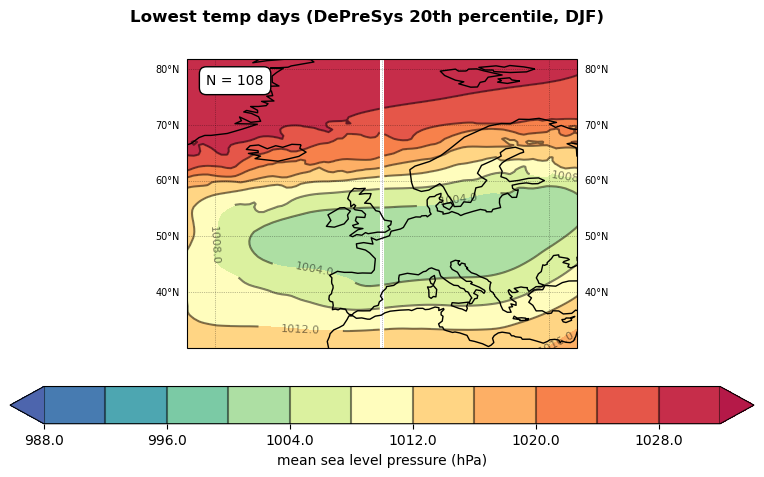

In [25]:
# plot the composite
plot_dps_composite(
    df=dps_df_subset_lowest_temp_20th,
    title="Lowest temp days (DePreSys 20th percentile, DJF)",
    lead="time_worst_tas_lead",
    anoms=False,
    composite=True,
    months=[12, 1, 2],
    climatology_years=[1990, 2020],
)

In [23]:
# data_wind_1th = dps_df["data_wind"].quantile(0.01)

# # subset the df to the 1th percentile of wind
# dps_df_subset_lowest_wind_1th = dps_df[dps_df["data_wind"] <= data_wind_1th]

In [24]:
# # calculate the 20th centile for data wind
# dps_data_wind_20th = dps_df["data_wind"].quantile(0.2)

# # subset the df to the 20th percentile of wind
# dps_df_subset_lowest_wind_20th = dps_df[dps_df["data_wind"] <= dps_data_wind_20th]

In [25]:
# # print the rows where dps_df_subset_lowest_wind_20th has effective dec year 2004
# dps_df_subset_lowest_wind_20th[dps_df_subset_lowest_wind_20th["effective_dec_year"] == 2004]

In [26]:
# # remove row at index 446 as a bodge fix
# dps_df_subset_lowest_wind_20th = dps_df_subset_lowest_wind_20th.drop(446)

In [27]:
# # test the function
# plot_dps_composite(
#     df=dps_df_subset_lowest_wind_20th,
#     title="Lowest wind days (DePreSys 20th percentile, DJF)",
#     lead="time_worst_wind_lead",
#     anoms=False,
#     composite=True,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

Some part of DePreSys processing doesn't appear to be working correctly. To check whether the method we are applying is valid, let's now check the Canari composites to see whether they look more realistic.

In [28]:
# Set up the path to the canari data
canari_path = "/home/users/benhutch/unseen_multi_year/dfs/Canari_worst_djf_wind_temp_days_DJF_1960-2013.csv"

# Load the data
canari_df = pd.read_csv(canari_path)

In [29]:
canari_df.head()

effective_dec_year  member time_worst_wind time_worst_tas  data_wind  \
0                1960       1      1961-01-30     1960-12-21   1.892235   
1                1960       2      1961-02-19     1961-02-02   2.027462   
2                1960       3      1960-12-03     1961-01-13   2.880504   
3                1960       4      1960-12-29     1961-01-23   1.600568   
4                1960       5      1960-12-26     1961-01-03   2.514957   

   data_tas_worst_wind  data_tas  data_wind_worst_tas  data_tas_dt  \
0             2.861436 -1.445395             2.481561     2.242008   
1             6.023582 -3.529893             3.503737     0.157511   
2            -1.685843 -6.243748             5.547405    -2.556345   
3            -1.297926 -5.877452             2.892183    -2.190049   
4             2.212363 -4.750289             4.193209    -1.062886   

   data_tas_worst_wind_dt  
0                6.548839  
1                9.710985  
2                2.001560  
3                2.389477  
4                5.899766

In [30]:
# # subset the cube to the 1th percentile of wind
canari_lowest_wind_1th = canari_df["data_wind"].quantile(0.01)

# # subset the df to the 1th percentile of wind
canari_df_subset_lowest_wind_1th = canari_df[canari_df["data_wind"] <= canari_lowest_wind_1th]

In [31]:
canari_df_subset_lowest_wind_1th.head()

effective_dec_year  member time_worst_wind time_worst_tas  data_wind  \
258                1966      19      1966-12-11     1966-12-29   1.553527   
323                1968       4      1969-01-12     1969-02-08   1.458429   
324                1968       5      1968-12-05     1968-12-13   1.523202   
492                1972      13      1972-12-20     1973-02-17   1.544104   
615                1975      16      1976-02-05     1975-12-02   1.507712   

     data_tas_worst_wind   data_tas  data_wind_worst_tas  data_tas_dt  \
258             1.892333 -10.344365             1.971412    -6.835544   
323             1.120310  -2.952701             2.837334     0.496593   
324            -4.031633  -6.634977             3.219194    -3.185684   
492             1.161670  -1.223123             4.799125     2.107116   
615             0.352577  -3.687092             2.213034    -0.446144   

     data_tas_worst_wind_dt  
258                5.401154  
323                4.569604  
324               -0.582339  
492                4.491909  
615                3.593525

In [32]:
# set up the 0.1th percentile for wind
canari_lowest_wind_0_1th = canari_df["data_wind"].quantile(0.001)

# subset the df to the 0.1th percentile of wind
canari_df_subset_lowest_wind_0_1th = canari_df[canari_df["data_wind"] <= canari_lowest_wind_0_1th]

In [33]:
canari_df_subset_lowest_wind_0_1th.head()

effective_dec_year  member time_worst_wind time_worst_tas  data_wind  \
323                 1968       4      1969-01-12     1969-02-08   1.458429   
1575                1999      16      2000-02-16     1999-12-29   1.462746   
1770                2004      11      2005-01-26     2005-02-04   1.423732   

      data_tas_worst_wind  data_tas  data_wind_worst_tas  data_tas_dt  \
323              1.120310 -2.952701             2.837334     0.496593   
1575             0.911395 -5.842302             2.628233    -3.315683   
1770             1.481174 -2.032958             4.720606     0.344843   

      data_tas_worst_wind_dt  
323                 4.569604  
1575                3.438015  
1770                3.858975

In [34]:
# %%time

# # test the function
# plot_canari_composite(
#     df=canari_df_subset_lowest_wind_0_1th,
#     title="Lowest wind days (CANARI 0.1th percentile, DJF)",
#     time="time_worst_wind",
#     anoms=False,
#     composite=False,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

Look into plotting the percentiles of temperature against wind speed.

Like in Thornton et al. (2017).

In [35]:
full_obs_df.head()

effective_dec_year  time_worst_wind  time_worst_tas  data_wind  \
0                1960               17              41   2.068829   
1                1961              107             121   2.006371   
2                1962              263             222   1.865907   
3                1963              278             289   2.263446   
4                1964              425             388   2.394781   

   data_tas_worst_wind  data_tas  data_wind_worst_tas  data_tas_dt  \
0             5.572500 -0.392873             3.525066     2.653499   
1             0.440456 -3.468196             3.471272    -0.463371   
2            -2.900903 -6.757083             2.923640    -3.793806   
3             1.783876 -2.562683             3.577491     0.359046   
4            -0.870013 -3.339781             4.008221    -0.459599   

   data_tas_worst_wind_dt time_worst_wind_date time_worst_tas_date  
0                8.618872           1960-12-18          1961-01-11  
1                3.445281           1961-12-18          1962-01-01  
2                0.062374           1963-02-22          1963-01-12  
3                4.705605           1963-12-09          1963-12-20  
4                2.010169           1965-02-03          1964-12-28

In [36]:
# set up the percentile thresholds
percentiles = np.arange(1, 101, 1)

# set up a new dataframe for the observations
obs_df_percentiles = pd.DataFrame()

# loop over the percentiles
for percentile in percentiles:
    # extract the percentile
    data_wind_percentile = full_obs_df["data_wind"].quantile(percentile / 100)
    data_tas_percentile = full_obs_df["data_tas_dt"].quantile(percentile / 100)

    # subset the df to the percentile
    obs_df_subset_percentile_wind = full_obs_df[full_obs_df["data_wind"] <= data_wind_percentile]
    obs_df_subset_percentile_temp = full_obs_df[full_obs_df["data_tas_dt"] <= data_tas_percentile]

    # Set up a new dataframe
    df_this = pd.DataFrame(
        {
            "percentile": [percentile],
            "threshold_data_wind": [data_wind_percentile],
            "threshold_data_tas_dt": [data_tas_percentile],
            "n_days_wind": [len(obs_df_subset_percentile_wind)],
            "n_days_tas_dt": [len(obs_df_subset_percentile_temp)],
            "mean_tas_dt_worst_wind": [obs_df_subset_percentile_wind["data_tas_worst_wind_dt"].mean()],
            "mean_wind_worst_tas_dt": [obs_df_subset_percentile_temp["data_wind_worst_tas"].mean()],
        }
    )

    # concat this to the percentiles dataframe
    obs_df_percentiles = pd.concat([obs_df_percentiles, df_this])

In [37]:
dps_df.head()

effective_dec_year  member  time_worst_wind  time_worst_tas  data_wind  \
0                1960       1               12              62   2.049034   
1                1960       2              116             119   1.820041   
2                1960       3              258             233   1.823847   
3                1960       4              282             354   2.067820   
4                1960       5              427             384   2.283272   

   data_tas_worst_wind  data_tas  data_wind_worst_tas  data_tas_dt  \
0             6.542990 -0.088807             3.649304     2.129563   
1             0.951182 -0.894575             3.437141     1.323794   
2             3.572365  0.071863             3.006122     2.290232   
3             4.440562  0.448920             4.191934     2.667290   
4             3.310963 -0.451000             3.762156     1.767369   

   data_tas_worst_wind_dt  time_worst_wind_lead  time_worst_tas_lead  
0                8.761359                    43                   93  
1                3.169551                    57                   60  
2                5.790735                   109                   84  
3                6.658931                    43                  115  
4                5.529332                    98                   55

In [38]:
# Do the same for the DePreSys data
dps_df_percentiles = pd.DataFrame()

# loop over the percentiles
for percentile in percentiles:
    # extract the percentile
    data_wind_percentile = dps_df["data_wind"].quantile(percentile / 100)
    data_tas_percentile = dps_df["data_tas_dt"].quantile(percentile / 100)

    # subset the df to the percentile
    dps_df_subset_percentile_wind = dps_df[dps_df["data_wind"] <= data_wind_percentile]
    dps_df_subset_percentile_temp = dps_df[dps_df["data_tas_dt"] <= data_tas_percentile]

    # Set up a new dataframe
    df_this = pd.DataFrame(
        {
            "percentile": [percentile],
            "threshold_data_wind": [data_wind_percentile],
            "threshold_data_tas_dt": [data_tas_percentile],
            "n_days_wind": [len(dps_df_subset_percentile_wind)],
            "n_days_tas_dt": [len(dps_df_subset_percentile_temp)],
            "mean_tas_dt_worst_wind": [dps_df_subset_percentile_wind["data_tas_worst_wind_dt"].mean()],
            "mean_wind_worst_tas": [dps_df_subset_percentile_temp["data_wind_worst_tas"].mean()],
        }
    )

    # concat this to the percentiles dataframe
    dps_df_percentiles = pd.concat([dps_df_percentiles, df_this])

In [39]:
canari_df.head()

effective_dec_year  member time_worst_wind time_worst_tas  data_wind  \
0                1960       1      1961-01-30     1960-12-21   1.892235   
1                1960       2      1961-02-19     1961-02-02   2.027462   
2                1960       3      1960-12-03     1961-01-13   2.880504   
3                1960       4      1960-12-29     1961-01-23   1.600568   
4                1960       5      1960-12-26     1961-01-03   2.514957   

   data_tas_worst_wind  data_tas  data_wind_worst_tas  data_tas_dt  \
0             2.861436 -1.445395             2.481561     2.242008   
1             6.023582 -3.529893             3.503737     0.157511   
2            -1.685843 -6.243748             5.547405    -2.556345   
3            -1.297926 -5.877452             2.892183    -2.190049   
4             2.212363 -4.750289             4.193209    -1.062886   

   data_tas_worst_wind_dt  
0                6.548839  
1                9.710985  
2                2.001560  
3                2.389477  
4                5.899766

In [40]:
# same for the canari data
canari_df_percentiles = pd.DataFrame()

# loop over the percentiles
for percentile in percentiles:
    # extract the percentile
    data_wind_percentile = canari_df["data_wind"].quantile(percentile / 100)
    data_tas_percentile = canari_df["data_tas_dt"].quantile(percentile / 100)

    # subset the df to the percentile
    canari_df_subset_percentile_wind = canari_df[canari_df["data_wind"] <= data_wind_percentile]
    canari_df_subset_percentile_temp = canari_df[canari_df["data_tas_dt"] <= data_tas_percentile]

    # Set up a new dataframe
    df_this = pd.DataFrame(
        {
            "percentile": [percentile],
            "threshold_data_wind": [data_wind_percentile],
            "threshold_data_tas_dt": [data_tas_percentile],
            "n_days_wind": [len(canari_df_subset_percentile_wind)],
            "n_days_tas_dt": [len(canari_df_subset_percentile_temp)],
            "mean_tas_dt_worst_wind": [canari_df_subset_percentile_wind["data_tas_worst_wind_dt"].mean()],
            "mean_wind_worst_tas": [canari_df_subset_percentile_temp["data_wind_worst_tas"].mean()],
        }
    )

    # concat this to the percentiles dataframe
    canari_df_percentiles = pd.concat([canari_df_percentiles, df_this])

In [41]:
obs_df_percentiles.columns

Index(['percentile', 'threshold_data_wind', 'threshold_data_tas_dt',
       'n_days_wind', 'n_days_tas_dt', 'mean_tas_dt_worst_wind',
       'mean_wind_worst_tas_dt'],
      dtype='object')

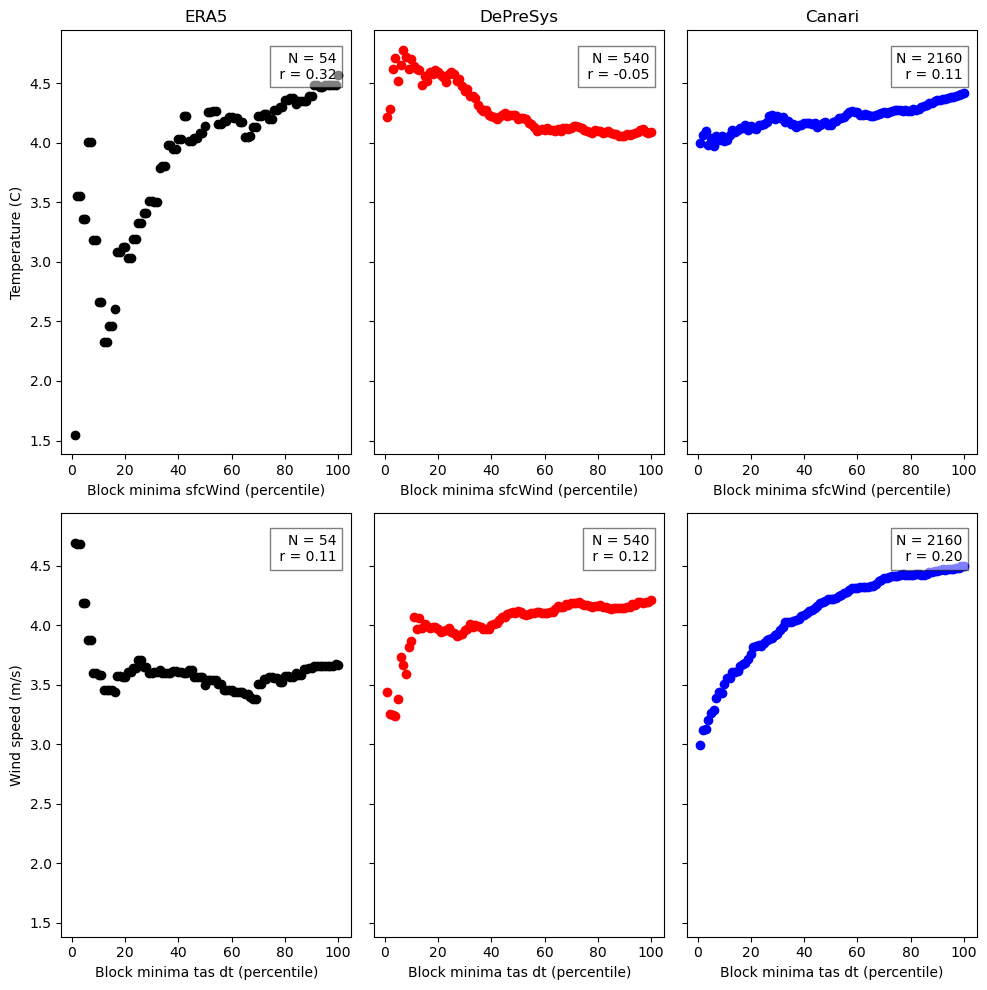

In [42]:
from scipy.stats import pearsonr

# Set up two subplots
# one row, two columns
fig, axs = plt.subplots(2, 3, figsize=(10, 10), sharey=True)

# Plot a scatter of the worst wind days
# with the tas values on these worst wind days
axs[0, 0].scatter(
    obs_df_percentiles["percentile"],
    obs_df_percentiles["mean_tas_dt_worst_wind"],
    color="black",
    label="ERA5 DJF block minima",
)

# calculate the correlation between full_obs_df["data_wind"] and full_obs_df["data_tas_dt"]
corr_obs_worst_wind_tas_dt, _ = pearsonr(full_obs_df["data_wind"], full_obs_df["data_tas_worst_wind_dt"])

# Set up the xlable
axs[0, 0].set_xlabel("Block minima sfcWind (percentile)")

# Set up the ylabel
axs[0, 0].set_ylabel("Temperature (C)")

# Set up the title
axs[0, 0].set_title("ERA5")

# # mark the max value of wind speed with a solid green vertical line
# axs[0].axvline(df_obs_worst_djf_days["data_wind"].max(), color="green", linestyle="-", label="ERA5 max")

# # mark the max value of temperature with a solid red horizontal line
# axs[0].axhline(df_obs_worst_djf_days["data_tas_dt"].max(), color="red", linestyle="-", label="ERA5 max")

# Plot a scatter
# of the worst temperature days
# with the wind values on these worst temperature days
axs[1, 0].scatter(
    obs_df_percentiles["percentile"],
    obs_df_percentiles["mean_wind_worst_tas_dt"],
    color="black",
    label="ERA5 DJF block minima",
)

# calculate the correlation between full_obs_df["data_tas_dt"] and full_obs_df["data_wind_worst_tas"]
corr_obs_worst_tas_dt_wind, _ = pearsonr(full_obs_df["data_tas_dt"], full_obs_df["data_wind_worst_tas"])

# Set up the xlable
axs[1, 0].set_xlabel("Block minima tas dt (percentile)")

# # Set up the xlable
# axs[1, 1].set_xlabel("Percentile of block minima Temperature (detrended)")

# set up the ylabel
axs[1, 0].set_ylabel("Wind speed (m/s)")

# # Set up the title
# axs[1, 0].set_title("ERA5")

# # set up a dashed blue line at 0
# axs[1, 0].axhline(0, color="blue", linestyle="--")

# # Calculate the 0th and 50th percentiles for wind speed
# wind_0th_percentile = df_obs_worst_djf_days["data_wind"].quantile(0.00)
# wind_50th_percentile = df_obs_worst_djf_days["data_wind"].quantile(0.50)

# # Calculate the 0th and 50th percentiles for temperature
# temp_0th_percentile = df_obs_worst_djf_days["data_tas_dt"].quantile(0.00)
# temp_50th_percentile = df_obs_worst_djf_days["data_tas_dt"].quantile(0.50)

# # Mark the 0th and 50th percentiles of wind speed with solid green vertical lines
# axs[1, 0].axvline(wind_0th_percentile, color="green", linestyle="-", label="ERA5 0th percentile")
# axs[1, 0].axvline(wind_50th_percentile, color="green", linestyle="-", label="ERA5 50th percentile")

# # Mark the 0th and 50th percentiles of temperature with solid red horizontal lines
# axs[1, 0].axhline(temp_0th_percentile, color="red", linestyle="-", label="ERA5 0th percentile")
# axs[1, 0].axhline(temp_50th_percentile, color="red", linestyle="-", label="ERA5 50th percentile")

# axs[0, 0].axvline(wind_0th_percentile, color="green", linestyle="-", label="ERA5 0th percentile")
# axs[0, 0].axvline(wind_50th_percentile, color="green", linestyle="-", label="ERA5 50th percentile")

# axs[0, 0].axhline(temp_0th_percentile, color="red", linestyle="-", label="ERA5 0th percentile")
# axs[0, 0].axhline(temp_50th_percentile, color="red", linestyle="-", label="ERA5 50th percentile")

# quantify the n points in the low wind, cold temp regions
#i.e. within both the 0th and 50th percentiles of wind speed and temperature
# n_points_worst_wind_cold_temp_obs = df_obs_worst_djf_days[
#     (df_obs_worst_djf_days["data_wind"] <= wind_50th_percentile)
#     & (df_obs_worst_djf_days["data_wind"] >= wind_0th_percentile)
#     & (df_obs_worst_djf_days["data_tas_worst_wind_dt"] <= temp_50th_percentile)
#     & (df_obs_worst_djf_days["data_tas_worst_wind_dt"] >= temp_0th_percentile)
# ].shape[0]

# n_points_worst_temp_low_wind_obs = df_obs_worst_djf_days[
#     (df_obs_worst_djf_days["data_wind_worst_tas"] <= wind_50th_percentile)
#     & (df_obs_worst_djf_days["data_wind_worst_tas"] >= wind_0th_percentile)
#     & (df_obs_worst_djf_days["data_tas_dt"] <= temp_50th_percentile)
#     & (df_obs_worst_djf_days["data_tas_dt"] >= temp_0th_percentile)
# ].shape[0]

# cinlude the total N points
axs[0, 0].text(
    0.95,
    0.95,
    f"N = {len(full_obs_df)}\n r = {corr_obs_worst_wind_tas_dt:.2f}",
    transform=axs[0, 0].transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
    horizontalalignment="right",
    verticalalignment="top",
)

# include the total N points
axs[1, 0].text(
    0.95,
    0.95,
    f"N = {len(full_obs_df)}\n r = {corr_obs_worst_tas_dt_wind:.2f}",
    transform=axs[1, 0].transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
    horizontalalignment="right",
    verticalalignment="top",
)

# # Shade the region where the 0th to 50th percentiles of wind speed and temperature intersect
# axs[0, 0].fill_betweenx(
#     [temp_0th_percentile, temp_50th_percentile],
#     wind_0th_percentile,
#     wind_50th_percentile,
#     color="gray",
#     alpha=0.3,
#     label="0th-50th percentile region"
# )

# # Shade the region where the 0th to 50th percentiles of wind speed and temperature intersect
# axs[1, 0].fill_betweenx(
#     [temp_0th_percentile, temp_50th_percentile],
#     wind_0th_percentile,
#     wind_50th_percentile,
#     color="gray",
#     alpha=0.3,
#     label="0th-50th percentile region"
# )

# # Add legend
# axs[0].legend()
# axs[1].legend()

# # include text on the lower red line in red, saying "cold temps"
# axs[1, 0].text(
#     8,
#     -4.8,
#     "cold temps",
#     color="red",
#     horizontalalignment="right",
# )

# # include vertical text on the left most green in green, saying "low wind"
# axs[1, 0].text(
#     1.8,
#     6,
#     "low wind",
#     color="green",
#     verticalalignment="top",
#     horizontalalignment="right",
#     rotation=270,
# )

# # set the xlims (1 -10)
# axs[1, 0].set_xlim(1, 9)

# # set the xlabel
# axs[1, 0].set_xlabel("Wind speed (m/s)")

# # set the ylabel
# axs[1, 0].set_ylabel("Temperature (C)")

# set up the third subplot
# Plot a scatter of the worst wind days
# for the model data
axs[0, 1].scatter(
    dps_df_percentiles["percentile"],
    dps_df_percentiles["mean_tas_dt_worst_wind"],
    color="red",
    label="DePreSys DJF block minima",
)

# calculate teh correlation
corr_dps_worst_wind_tas_dt, _ = pearsonr(dps_df["data_wind"], dps_df["data_tas_worst_wind_dt"])

# Set up the xlable
# axs[1, 0].set_xlabel("Wind speed (m/s)")
axs[0, 1].set_xlabel("Block minima sfcWind (percentile)")

# # set up the ylabel
# axs[0, 1].set_ylabel("Temperature (C)")

# set up the title
axs[0, 1].set_title("DePreSys")

# set up a dashed blue line at 0
# axs[1, 0].axhline(0, color="blue", linestyle="--")

# # set the xlims (1 -10)
# axs[0, 1].set_xlim(1, 9)

# Plot a scatter
# of the worst temperature days
# for the model data
axs[1, 1].scatter(
    dps_df_percentiles["percentile"],
    dps_df_percentiles["mean_wind_worst_tas"],
    color="red",
    label="DePreSys DJF block minima",
)

# Calculate the correlation
corr_dps_worst_tas_dt_wind, _ = pearsonr(dps_df["data_tas_dt"], dps_df["data_wind_worst_tas"])

# Set up the xlable
axs[1, 1].set_xlabel("Block minima tas dt (percentile)")

# Set up the title
# axs[1, 1].set_title("DePreSys")

# set up a dashed blue line at 0
# axs[1, 1].axhline(0, color="blue", linestyle="--")

# Calculate the 0th and 50th percentiles for wind speed
# wind_0th_percentile = df_model_worst_djf_days["data_wind"].quantile(0.00)
# wind_50th_percentile = df_model_worst_djf_days["data_wind"].quantile(0.50)

# # Calculate the 0th and 50th percentiles for temperature
# temp_0th_percentile = df_model_worst_djf_days["data_tas_dt"].quantile(0.00)
# temp_50th_percentile = df_model_worst_djf_days["data_tas_dt"].quantile(0.50)

# # Mark the 0th and 50th percentiles of wind speed with solid green vertical lines
# axs[1, 1].axvline(wind_0th_percentile, color="green", linestyle="-", label="DePreSys 0th percentile")
# axs[1, 1].axvline(wind_50th_percentile, color="green", linestyle="-", label="DePreSys 50th percentile")

# # Mark the 0th and 50th percentiles of temperature with solid red horizontal lines
# axs[1, 1].axhline(temp_0th_percentile, color="red", linestyle="-", label="DePreSys 0th percentile")
# axs[1, 1].axhline(temp_50th_percentile, color="red", linestyle="-", label="DePreSys 50th percentile")

# axs[0, 1].axvline(wind_0th_percentile, color="green", linestyle="-", label="DePreSys 0th percentile")
# axs[0, 1].axvline(wind_50th_percentile, color="green", linestyle="-", label="DePreSys 50th percentile")

# axs[0, 1].axhline(temp_0th_percentile, color="red", linestyle="-", label="DePreSys 0th percentile")
# axs[0, 1].axhline(temp_50th_percentile, color="red", linestyle="-", label="DePreSys 50th percentile")

# # include the total N points
# n_points_worst_wind_cold_temp_dps = df_model_worst_djf_days[
#     (df_model_worst_djf_days["data_wind"] <= wind_50th_percentile)
#     & (df_model_worst_djf_days["data_wind"] >= wind_0th_percentile)
#     & (df_model_worst_djf_days["data_tas_worst_wind_dt"] <= temp_50th_percentile)
#     & (df_model_worst_djf_days["data_tas_worst_wind_dt"] >= temp_0th_percentile)
# ].shape[0]

# n_points_worst_temp_low_wind_dps = df_model_worst_djf_days[
#     (df_model_worst_djf_days["data_wind_worst_tas"] <= wind_50th_percentile)
#     & (df_model_worst_djf_days["data_wind_worst_tas"] >= wind_0th_percentile)
#     & (df_model_worst_djf_days["data_tas_dt"] <= temp_50th_percentile)
#     & (df_model_worst_djf_days["data_tas_dt"] >= temp_0th_percentile)
# ].shape[0]

# cinlude the total N points
axs[0, 1].text(
    0.95,
    0.95,
    f"N = {len(dps_df)}\n r = {corr_dps_worst_wind_tas_dt:.2f}",
    transform=axs[0, 1].transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
    horizontalalignment="right",
    verticalalignment="top",
)

# include the total N points
axs[1, 1].text(
    0.95,
    0.95,
    f"N = {len(dps_df)}\n r = {corr_dps_worst_tas_dt_wind:.2f}",
    transform=axs[1, 1].transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
    horizontalalignment="right",
    verticalalignment="top",
)

# Shade the region where the 0th to 50th percentiles of wind speed and temperature intersect
# axs[0, 1].fill_betweenx(
#     [temp_0th_percentile, temp_50th_percentile],
#     wind_0th_percentile,
#     wind_50th_percentile,
#     color="gray",
#     alpha=0.3,
#     label="0th-50th percentile region"
# )

# # Shade the region where the 0th to 50th percentiles of wind speed and temperature intersect
# axs[1, 1].fill_betweenx(
#     [temp_0th_percentile, temp_50th_percentile],
#     wind_0th_percentile,
#     wind_50th_percentile,
#     color="gray",
#     alpha=0.3,
#     label="0th-50th percentile region"
# )

# in position 0, 2
#plot the canari data
axs[0, 2].scatter(
    canari_df_percentiles["percentile"],
    canari_df_percentiles["mean_tas_dt_worst_wind"],
    color="blue",
    label="Canari DJF block minima",
)

# Calculate the correlations
corr_canari_worst_wind_tas_dt, _ = pearsonr(canari_df["data_wind"], canari_df["data_tas_worst_wind_dt"])

# Set up the title
axs[0, 2].set_title("Canari")

# Set up the xlable
axs[0, 2].set_xlabel("Block minima sfcWind (percentile)")

# # set up the horizontal lines for the 0th and 50th percentiles
# axs[0, 2].axhline(temp_0th_percentile, color="red", linestyle="-", label="Canari 0th percentile")
# axs[0, 2].axhline(temp_50th_percentile, color="red", linestyle="-", label="Canari 50th percentile")

# # set up the vertical lines for the 0th and 50th percentiles
# axs[0, 2].axvline(wind_0th_percentile, color="green", linestyle="-", label="Canari 0th percentile")
# axs[0, 2].axvline(wind_50th_percentile, color="green", linestyle="-", label="Canari 50th percentile")

# # highlight the region where the 0th to 50th percentiles intersect
# axs[0, 2].fill_betweenx(
#     [temp_0th_percentile, temp_50th_percentile],
#     wind_0th_percentile,
#     wind_50th_percentile,
#     color="gray",
#     alpha=0.3,
#     label="0th-50th percentile region"
# )

# # Plot a scatter
# # of the worst temperature days
# # for the model data
axs[1, 2].scatter(
    canari_df_percentiles["percentile"],
    canari_df_percentiles["mean_wind_worst_tas"],
    color="blue",
    label="Canari DJF block minima",
)

# calculate the correlations
corr_canari_worst_tas_dt_wind, _ = pearsonr(canari_df["data_tas_dt"], canari_df["data_wind_worst_tas"])

# Set up the xlable
axs[1, 2].set_xlabel("Block minima tas dt (percentile)")

# Set up the title
# axs[1, 1].set_title("Canari")

# set up a dashed blue line at 0
# axs[1, 1].axhline(0, color="blue", linestyle="--")

# Calculate the 0th and 50th percentiles for wind speed
# wind_0th_percentile = df_canari_worst_djf_days["data_wind"].quantile(0.00)

# highlight the regions
# axs[1, 2].axvline(wind_0th_percentile, color="green", linestyle="-", label="Canari 0th percentile")
# axs[1, 2].axvline(wind_50th_percentile, color="green", linestyle="-", label="Canari 50th percentile")

# # highlight the regions
# axs[1, 2].axhline(temp_0th_percentile, color="red", linestyle="-", label="Canari 0th percentile")
# axs[1, 2].axhline(temp_50th_percentile, color="red", linestyle="-", label="Canari 50th percentile")

# highlight the region
# axs[1, 2].fill_betweenx(
#     [temp_0th_percentile, temp_50th_percentile],
#     wind_0th_percentile,
#     wind_50th_percentile,
#     color="gray",
#     alpha=0.3,
#     label="0th-50th percentile region"
# )

# # include the total N points
# n_points_worst_wind_cold_temp_canari = df_canari_worst_djf_days[
#     (df_canari_worst_djf_days["data_wind"] <= wind_50th_percentile)
#     & (df_canari_worst_djf_days["data_wind"] >= wind_0th_percentile)
#     & (df_canari_worst_djf_days["data_tas_worst_wind_dt"] <= temp_50th_percentile)
#     & (df_canari_worst_djf_days["data_tas_worst_wind_dt"] >= temp_0th_percentile)
# ].shape[0]

# n_points_worst_temp_low_wind_canari = df_canari_worst_djf_days[
#     (df_canari_worst_djf_days["data_wind_worst_tas"] <= wind_50th_percentile)
#     & (df_canari_worst_djf_days["data_wind_worst_tas"] >= wind_0th_percentile)
#     & (df_canari_worst_djf_days["data_tas_dt"] <= temp_50th_percentile)
#     & (df_canari_worst_djf_days["data_tas_dt"] >= temp_0th_percentile)
# ].shape[0]

# cinlude the total N points
axs[0, 2].text(
    0.95,
    0.95,
    f"N = {len(canari_df)}\n r = {corr_canari_worst_wind_tas_dt:.2f}",
    transform=axs[0, 2].transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
    horizontalalignment="right",
    verticalalignment="top",
)

# include the total N points
axs[1, 2].text(
    0.95,
    0.95,
    f"N = {len(canari_df)}\n r = {corr_canari_worst_tas_dt_wind:.2f}",
    transform=axs[1, 2].transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
    horizontalalignment="right",
    verticalalignment="top",
)

# set a tight layout
plt.tight_layout()